In [178]:
import pandas as pd
import numpy as np

In [179]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

<h1> Looking at wine data quality from physicochemical properties</h1>

This note book takes data from this data set https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data and analyses the effect of parameter tuning on a machine learnings ability to predict wine quality from physicochecmical properties.
The notebook is split into sections as per the contents below.

## Contents:
* [Loading and inspecting the data set](#loading-inspecting)
* [Selecting a Model](#model-selection)
* [Hyperparameter tuning](#parameter-tuning)

# Loading and inspecting the data set
<a class="anchor" id="loading-inspecting"></a>

In [180]:
#df = pd.read_csv('./wine_quality/winequality-red.csv', sep=';')
#df = pd.read_csv('./wine_quality/winequality-white.csv', sep=';')
df = pd.read_csv('./data.csv')

## Taking a look at the data 

In [181]:
print("Shape of data:", df.shape)
print(df.info())
df.head()

Shape of data: (1143, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


## Performing some basic checks on the data

Checking data quality..
Number of variable null valuess:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

Number of duplicate entries: 0
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.60

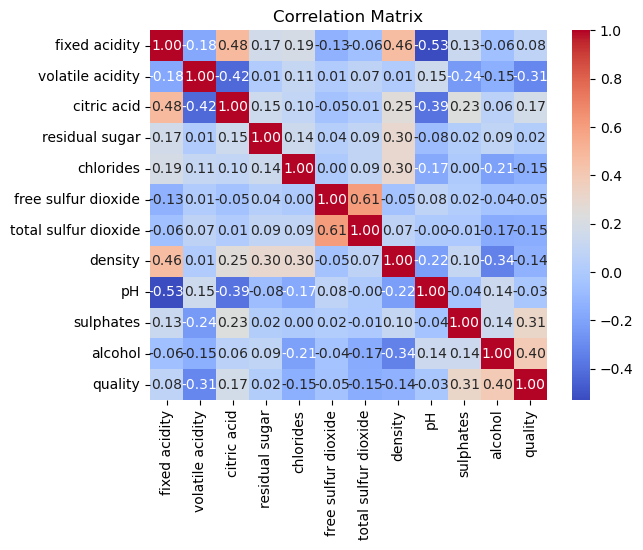

In [222]:
bld = "\033[1m"
end_bld = "\033[0m" 

#Existing quality values in the data
print("Checking data quality..")
print(bld+"Number of variable null valuess:"+end_bld)
print(df.isnull().sum())
print(bld+"\nNumber of duplicate entries:"+end_bld, df.duplicated().sum())

# Calculate basic statistics
statistics = df.describe()
print(statistics)

print("\n\nLooking at the output values... column 'quality'")
unique_classes = df["quality"].unique()
print(bld+"Unique quality values:"+end_bld,unique_classes)
print(bld+"Instance count of quality values:"+end_bld)
print(df["quality"].value_counts())

print("\n\nLooking at the correlations in the data:")
corr_df = df.copy()[[col for col in df.columns if 'Id' not in col]]
corr_df["quality"] = df["quality"].astype('int')
correlation_matrix = corr_df.corr(method='kendall')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Preparing the data for analysis

Data needs to be prepared for analysis and looking at the results from inspection we will need to address the following issues:

* The range of the variables is very different so we might need some normalisation
* Quality is a numerical value so can be made a string class
* Dropping and Id columns where they exist

In [220]:
print(bld+"Preparing the 'data' with:"+end_bld)

print("Replacing the quality variable with a string for easy classification...")
data = df.copy()
data["quality"] = data["quality"].astype(str)

print("Drop the wine Id column if using Kaggle set not raw white and red...")
data = data[[col for col in df.columns if 'Id' not in col]]

print("Scaling the data...")
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.iloc[:,:-1]),columns = data.columns[:-1]) #scale the predictors
data_scaled["quality"] = data.quality.copy()

Preparing the 'data' with:
Replacing the quality variable with a string for easy classification...
Drop the wine Id column if using Kaggle set not raw white and red...
Scaling the data...


In [184]:
#Split the data into test and training sets
test_size = 0.2
print("Splitting the data in training and test sets with test ratio", test_size, "...")
train, test = train_test_split(data_scaled, test_size=test_size) 

#Split the data into inputs and outputs
def input_and_outputs(data_in, y_col="quality"):
    return data_in.loc[:, data_in.columns != y_col], data_in.loc[:, y_col]

X_values, y_values = input_and_outputs(data_scaled)
X_train, y_train = input_and_outputs(train)
X_test, y_test = input_and_outputs(test)

print("Due to the imbalance in the data set in terms of sample we over sample to try to improve performance on the classifiers")
print("Previous instance counts:", y_train.value_counts())
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

print("New class instance counts:", y_train_resampled.value_counts())

Splitting the data in training and test sets with test ratio 0.2 ...
Due to the imbalance in the data set in terms of sample we over sample to try to improve performance on the classifiers
Previous instance counts: 5    384
6    374
7    114
4     25
8     13
3      4
Name: quality, dtype: int64
New class instance counts: 6    384
5    384
4    384
7    384
8    384
3    384
Name: quality, dtype: int64


# Testing different models on the data
<a class="anchor" id="model-selection"></a>
In order to select a model I look at a few different options and compare their performance metrics to see which are performing better than the other before trying to tune the parameters.

##### Cluster view: An interesting look at the data to see if it splits into 6 different groups
Using clustering I would like to see if this matches the quality predictions in future

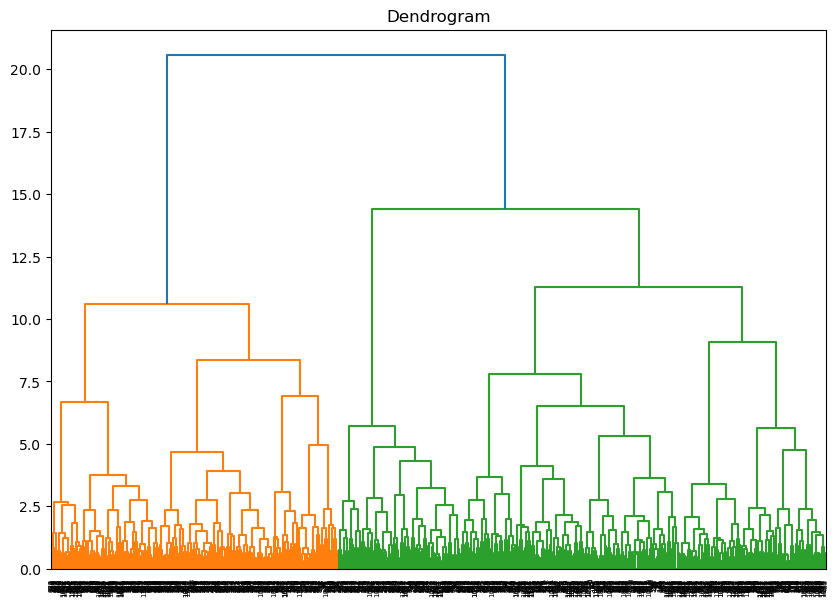

In [185]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

data_scaled = normalize(X_values)
data_scaled = pd.DataFrame(data_scaled, columns=X_values.columns)
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

#cluster = AgglomerativeClustering(n_clusters = 6, metric='euclidean', linkage='ward')  
#cluster.fit_predict(data_scaled)

##### Preparing a set of default classifiers for the problem 

In [203]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Set a universal threshold for classification
threshold = 0.5

# Set up multiple models in a dictionary
models = {
    "logistic_regression": LogisticRegression(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "k_nearest_neighbors": KNeighborsClassifier(),
    "support_vector_machine": SVC(),
    "gradient_boosting": GradientBoostingClassifier(),
    "naive_bayes": GaussianNB()
}

decision_tree


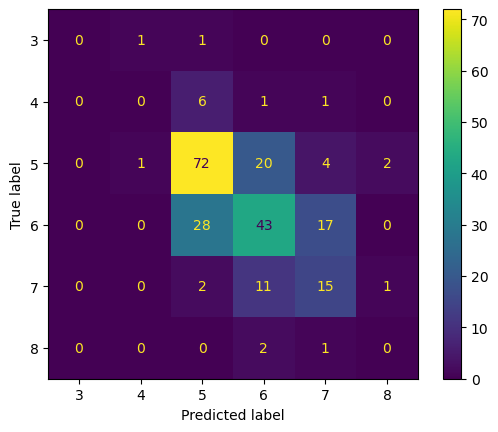

random_forest


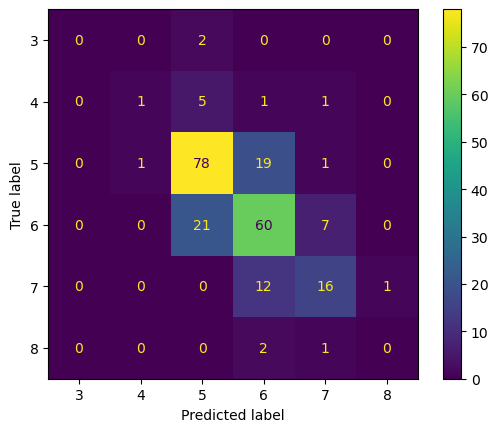

k_nearest_neighbors


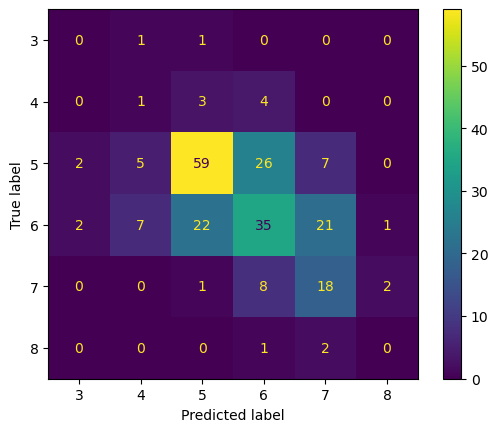

support_vector_machine


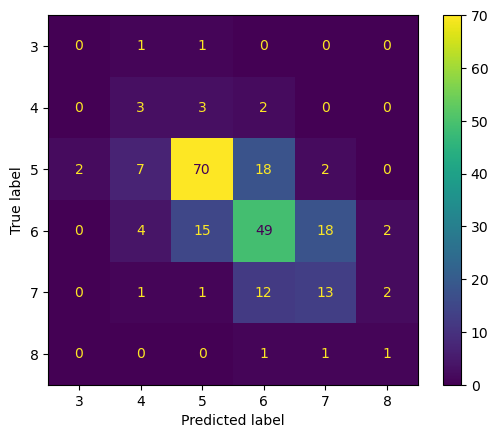

gradient_boosting


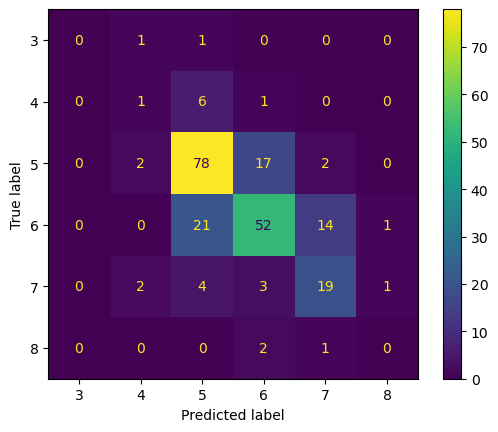

naive_bayes


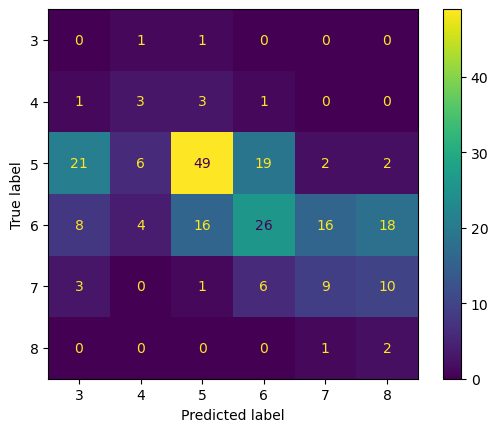

In [205]:
def accuracy_scores(cm):
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
    return class_accuracies
    
#AKA true negative rate
def calc_specificity(cm):
    values = []
    for class_index in range(len(cm)):
        true_negatives = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
        false_positives = np.sum(np.delete(cm[class_index, :], class_index))
        if (false_positives + true_negatives) == 0:
            specificity = 0
        else: 
            specificity = true_negatives / (true_negatives + false_positives)
        values.append(specificity)
    return values

def calc_precision(cm):
    precisions = []
    for i in range(len(cm)):
        true_positive = cm[i, i]
        false_positive = np.sum(cm[:, i]) - true_positive
        if (false_positive + true_positive) == 0:
            precision = 0
        else: 
            precision = true_positive / (true_positive + false_positive)
        precisions.append(precision)
    return precisions
    
#AKA recall
def calc_sensitivity(cm):
    values = []
    for class_index in range(len(cm)):
        true_positives = cm[class_index, class_index]
        false_negatives = np.sum(np.delete(cm[class_index, :], class_index))
        if (true_positives + false_negatives) == 0:
            specificity = 0
        else: 
            specificity = true_positives / (true_positives + false_negatives)
        values.append(specificity)
    return values

overall_results = []
raw_results = []

def run():
    for key in models.keys():
        print(key)

        # 1 Fit the classifier model
        current_model = models[key]
        current_model.fit(X_train_resampled, y_train_resampled)

        #2 Prediction  on test set
        predictions = current_model.predict(X_test) 


        #3 Calculate some performance metrics to view and compare
        cm = confusion_matrix(y_test, predictions)
        #print(cm)

        #Filter the classes incase any are missing 
        test_classes = [x for x in current_model.classes_ if x in y_test.unique()]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_classes)
        precision_raw = calc_precision(cm)
        recall_raw = calc_sensitivity(cm)
        true_negative_rate_raw = calc_specificity(cm)

        overall_results.append({
            "model": key,
            "accuracy_score": accuracy_score(y_test, predictions),
            "precision": np.mean(precision_raw),
            "recall": np.mean(recall_raw),
            "true_negative_rate": np.mean(true_negative_rate_raw),
        })
        #print(pd.DataFrame(overall_results))

        raw_results.append({
            "model": key,
            "accuracy_raw": accuracy_scores(cm),
            "precision_raw": precision_raw,
            "recall_raw": recall_raw,
            "true_negative_rate_raw": true_negative_rate_raw,
            "test_class": test_classes
        })
        #print(pd.DataFrame(raw_results))
        disp.plot()
        plt.show()
        
run()

In [188]:
overall_results_df = pd.DataFrame(overall_results)
overall_results_df.set_index('model', inplace=True)
overall_results_df = overall_results_df.sort_values(by=["accuracy_score"], ascending=False)
overall_results_df.head(len(models))

,accuracy_score,precision,recall,true_negative_rate
model,,,,
random_forest,0.672489,0.492716,0.348768,0.916270
gradient_boosting,0.655022,0.349478,0.359827,0.914102
support_vector_machine,0.593886,0.357532,0.403416,0.900466
decision_tree,0.519651,0.242572,0.257307,0.879128
k_nearest_neighbors,0.493450,0.267575,0.289896,0.877142
logistic_regression,0.484716,0.340381,0.551303,0.882407
naive_bayes,0.388646,0.299702,0.357069,0.866202


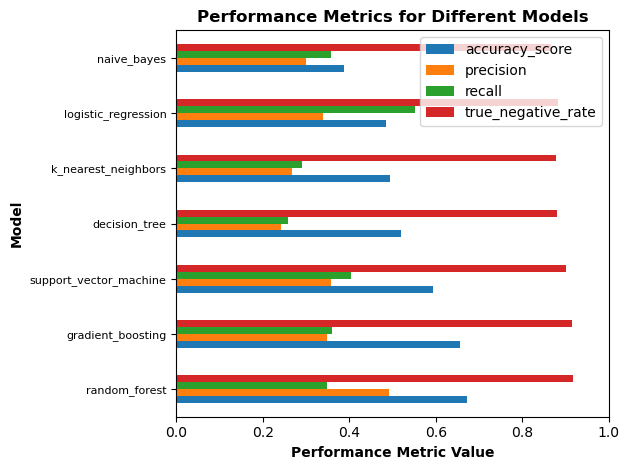

In [189]:
ax = overall_results_df.plot.barh()

plt.yticks(range(len(overall_results_df.index)), overall_results_df.index, fontsize=8)
plt.xlim(0.0, 1.0)

plt.xlabel('Performance Metric Value', fontweight='bold')
plt.ylabel('Model', fontweight='bold')
plt.title('Performance Metrics for Different Models', fontweight='bold')

plt.tight_layout()

In [190]:
results_exploded = [];
results_flattened = [];

for raw_result in raw_results:
    for idx, class_name in enumerate(raw_result["test_class"]):
        results_exploded.append({
            "model": raw_result["model"],
            "class_name": class_name,
            "accuracy": raw_result["accuracy_raw"][idx],
            "precision": raw_result["precision_raw"][idx],
            "recall": raw_result["recall_raw"][idx],
            "true_negative_rate": raw_result["true_negative_rate_raw"][idx],
        })
    
overall_class_results_df = pd.DataFrame(results_exploded)
overall_class_results_df.head(20)
overall_class_results_df = overall_class_results_df.sort_values(by=["accuracy"], ascending=False)

grouped_raw_results = overall_class_results_df.groupby(["class_name", "model"]).agg({
    "accuracy": 'mean',
    "precision": 'mean',
    "recall": 'mean',
    "true_negative_rate": 'mean'
})
grouped_raw_results#.sort_values(by=["accuracy"], ascending=False)


accuracy  precision    recall  \
class_name model                                                   
3          decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.000000   0.000000  0.000000   
           logistic_regression     0.500000   0.083333  0.500000   
           naive_bayes             0.000000   0.000000  0.000000   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.000000   0.000000  0.000000   
4          decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.125000   0.166667  0.125000   
           k_nearest_neighbors     0.125000   0.071429  0.125000   
           logistic_regression     0.500000   0.142857  0.500000   
           naive_bayes             0.375000   0.214286  0.375000   
           random_forest           0.125000   1.000000  0.125000   
           support_vector_machine  0.375000   0.187500  0.375000   
5          decision_tree           0.686869   0.612613  0.686869   
           gradient_boosting       0.787879   0.709091  0.787879   
           k_nearest_neighbors     0.595960   0.686047  0.595960   
           logistic_regression     0.565657   0.777778  0.565657   
           naive_bayes             0.494949   0.700000  0.494949   
           random_forest           0.757576   0.757576  0.757576   
           support_vector_machine  0.707071   0.777778  0.707071   
6          decision_tree           0.443182   0.527027  0.443182   
           gradient_boosting       0.590909   0.693333  0.590909   
           k_nearest_neighbors     0.397727   0.472973  0.397727   
           logistic_regression     0.431818   0.567164  0.431818   
           naive_bayes             0.295455   0.500000  0.295455   
           random_forest           0.727273   0.615385  0.727273   
           support_vector_machine  0.556818   0.597561  0.556818   
7          decision_tree           0.413793   0.315789  0.413793   
           gradient_boosting       0.655172   0.527778  0.655172   
           k_nearest_neighbors     0.620690   0.375000  0.620690   
           logistic_regression     0.310345   0.346154  0.310345   
           naive_bayes             0.310345   0.321429  0.310345   
           random_forest           0.482759   0.583333  0.482759   
           support_vector_machine  0.448276   0.382353  0.448276   
8          decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.000000   0.000000  0.000000   
           logistic_regression     1.000000   0.125000  1.000000   
           naive_bayes             0.666667   0.062500  0.666667   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.333333   0.200000  0.333333   

                                   true_negative_rate  
class_name model                                       
3          decision_tree                     0.991228  
           gradient_boosting                 0.991266  
           k_nearest_neighbors               0.991111  
           logistic_regression               0.995392  
           naive_bayes                       0.989796  
           random_forest                     0.991266  
           support_vector_machine            0.991189  
4          decision_tree                     0.964602  
           gradient_boosting                 0.968610  
           k_nearest_neighbors               0.967442  
           logistic_regression               0.980100  
           naive_bayes                       0.976744  
           random_forest                     0.969298  
           support_vector_machine            0.976526  
5          decision_tree                     0.737288  
           gradient_boosting                 0.823529  
           k_nearest_neighbors    

In [191]:
#ax = grouped_raw_results.plot.barh()
#plt.yticks(range(len(grouped_raw_results.index)), grouped_raw_results.index, fontsize=8)
#plt.xlim(0.0, 1.0)
#plt.xlabel('Performance Metric Value', fontweight='bold')
#plt.ylabel('Model', fontweight='bold')
#plt.title('Performance Metrics for Different Models', fontweight='bold')

# Parameter Tuning the random forest
<a class="anchor" id="parameter-tuning"></a>

The best model so far has been the RandomForestClassifier so i will use this to test hyperparameter tuning initially

## Bayes optimisation for hyperparameter search

In [200]:
np.int = int
#Perform hyperparameter tuning with the BayesSearchCV using Bayesian optimization.
def tune_parameters(X, y, model, param_space, n_iter=50, cv=5, random_state=None):
    # Initialize Bayesian optimization
    bayes_opt = BayesSearchCV(model, param_space, n_iter=n_iter, cv=cv, random_state=random_state, n_jobs=-1)
    # Perform parameter tuning
    bayes_opt.fit(X, y)
    # Return the best estimator and best hyperparameters: 
    return bayes_opt.best_estimator_, bayes_opt.best_params_

# Define the search space for hyperparameters
param_space = {
    'n_estimators': Integer(10, 200),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion': Categorical(['gini', 'entropy'])
}

# Initialize the classifier model
model = RandomForestClassifier()

# Tune hyperparameters using Bayesian optimization
best_model, best_params = tune_parameters(X_train_resampled, y_train_resampled, model, param_space, n_iter=50, cv=5, random_state=42)

# Evaluate the best classifier
score = best_model.score(X_test, y_test)
print("Model feature importance:", best_model.feature_importances_)
print("Best classifier accuracy:", score)

/Users/lilawr/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/lilawr/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/lilawr/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/lilawr/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/lilawr/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

Best classifier accuracy: 0.6593886462882096


## Grid search for hyperparameter search

In [224]:
#Perform hyperparameter tuning using GridSearchCV.
def tune_parameters_with_grid_search(X, y, model, param_grid, cv=5):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    # Perform parameter tuning
    grid_search.fit(X, y)
    # Return the best estimator
    return grid_search.best_estimator_, grid_search.best_params_

# Define the search grid for hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the classifier model
model = RandomForestClassifier()

# Tune hyperparameters using GridSearchCV
best_model, best_params = tune_parameters_with_grid_search(X_train_resampled, y_train_resampled,model, param_grid, cv=5)
print("Model feature importance:", best_model.feature_importances_)
# Evaluate the best classifier
score = best_model.score(X_test, y_test)
print("Best classifier accuracy:", score)

Best classifier accuracy: 0.6637554585152838


## Checking the model against the other with parameter search

In [234]:
param_for_models = {
    "logistic_regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],               # Type of regularization
        'solver': ['liblinear', 'saga']        # Solver algorithm
    },
    "decision_tree": {
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "random_forest": {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "k_nearest_neighbors": {
        'n_neighbors': [3, 5, 7, 9],        # Number of neighbors to consider
        'weights': ['uniform', 'distance'],  # Weighting scheme
        'p': [1, 2], 
    },
    "support_vector_machine": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'kernel': ['linear', 'rbf'],      # Kernel function
        'gamma': [0.01, 0.1, 1, 'auto'] ,  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    },
    "gradient_boosting":{
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "naive_bayes": { 
    #No parameters to tune
    }
}

In [236]:
tuning_results = []

def run_tuning():
    for key in models.keys():
        print(key)

        # 1 Fit the classifier model
        current_model = models[key]
        param_grid = param_for_models.get(key)
        
        best_model, best_params = tune_parameters_with_grid_search(X_train_resampled, y_train_resampled, current_model, param_grid, cv=5)
        score = best_model.score(X_test, y_test)

        tuning_results.append({**{
            "model": key,
            "tuning_type": "grid",
            "best_accuracy_score": score,
        },**best_params}) 
        
run_tuning()

tuning_df = pd.DataFrame(tuning_results)
tuning_df.head()

decision_tree
random_forest
k_nearest_neighbors
support_vector_machine
gradient_boosting
naive_bayes


,model,tuning_type,best_accuracy_score,max_depth,min_samples_leaf,min_samples_split,n_estimators,n_neighbors,p,weights,C,gamma,kernel,learning_rate
0,decision_tree,grid,0.362445,5.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,random_forest,grid,0.663755,30.0,1.0,2.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,k_nearest_neighbors,grid,0.637555,NaN,NaN,NaN,NaN,3.0,1.0,distance,NaN,NaN,NaN,NaN
3,support_vector_machine,grid,0.624454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,rbf,NaN
4,gradient_boosting,grid,0.655022,4.0,1.0,10.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,0.2
